# Open modification searching: Precursor mass differences

In [1]:
import os
import sys

src_dir = os.path.abspath('../src')
if src_dir not in sys.path:
    sys.path.append(src_dir)

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import seaborn as sns
import sklearn.cluster

import reader
import util

In [3]:
# plot styling
plt.style.use(['seaborn-white', 'seaborn-paper'])
plt.rc('font', family='serif')
sns.set_palette('Set1')

In [4]:
max_fdr = 0.01
bandwidth = 0.05
min_cluster_size = 5

In [5]:
filename = '../data/processed/iprg2012/bf_oms.mztab'
psms = util.filter_group_fdr(reader.read_mztab_psms(filename), max_fdr, bandwidth)

In [6]:
# find mass difference clusters
psms['mass_diff'] = (
    (psms['exp_mass_to_charge'] - psms['calc_mass_to_charge']) * psms['charge']
)
mean_shift = sklearn.cluster.MeanShift(bandwidth,
                                       min_bin_freq=min_cluster_size,
                                       cluster_all=False, n_jobs=-1)
clusters = mean_shift.fit_predict(psms['mass_diff'].values.reshape(-1, 1))
# discard clusters with too few elements
labels, sizes = np.unique(clusters, return_counts=True)
small_cluster_labels = labels[np.where(sizes < min_cluster_size)[0]]
clusters[np.isin(clusters, small_cluster_labels)] = -1
# count the number of PSMs in each cluster
psm_clusters = psms.groupby(clusters)['mass_diff'].agg(['median', 'size'])

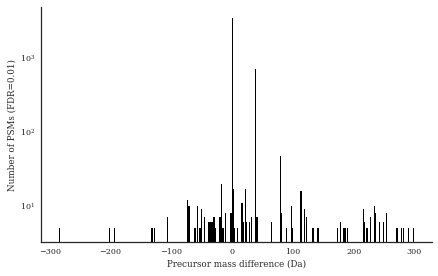

In [7]:
width = 7
height = width / 1.618    # golden ratio
fig, ax = plt.subplots(figsize=(width, height))

ax.bar(psm_clusters['median'].values, psm_clusters['size'].values,
       width=2, log=True, color='black')

ax.set_xlabel('Precursor mass difference (Da)')
ax.set_ylabel('Number of PSMs (FDR={})'.format(max_fdr))

# set tick labels at nice positions
ax.xaxis.set_major_locator(mticker.MultipleLocator(100))

sns.despine()

plt.savefig('mass_diff.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()